In [62]:
%matplotlib inline
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask
import datetime as dt
import multiprocessing
import folium
import branca
import branca.colormap as cm
import pylab
import random as rd
import geopandas
import seaborn
import time

from datetime import datetime, date
from shapely.geometry import Point, Polygon, MultiPolygon
from tqdm.notebook import tqdm
from collections import Counter
from folium.plugins import HeatMap
from folium.features import DivIcon
from numba import jit
from folium.plugins import HeatMapWithTime

# Single machine progress bar
from dask.diagnostics import ProgressBar

pd.options.display.precision = 2
#pd.set_option('display.max_columns', None)
nbRowsToDisplay = 100
pd.options.display.min_rows = nbRowsToDisplay
pd.options.display.max_rows = nbRowsToDisplay
plt.rcParams["figure.figsize"] = (20,10)

In [63]:
#Define a function to display an heatmap
Cph_Lat = 12.5683
Cph_Long = 55.6761

#Create a gradient map
steps = 20
#color_map=cm.linear.Accent_07.scale(0,1).to_step(steps)
color_map = cm.LinearColormap(['blue', 'yellow', 'red'],vmin=0, vmax=1)
#color_map1 = cm.LinearColormap(['blue', 'yellow', 'red'],vmin=0, vmax=120)

gradient_map={}
for i in range(steps):
    gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)

def generateBaseMap(default_location=[Cph_Long, Cph_Lat], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=12,tiles=None)
    folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(base_map)
    return base_map

def plotHeatmapWithTime(data,index):
    
    heatmap = generateBaseMap() #Base map
    
    #Heatmap
    heatmap.add_child(HeatMapWithTime(data, radius=5,index=index,  gradient=gradient_map))
    
    color_map.add_to(heatmap) #Color bar
    
    return heatmap

In [64]:
def plotHeatmapWithTime(data,index):
    
    heatmap = generateBaseMap() #Base map
    
    #Heatmap
    heatmap.add_child(HeatMapWithTime(data, radius=5,index=index,  gradient=gradient_map))
    
    color_map.add_to(heatmap) #Color bar
    
    return heatmap

In [65]:
fileDirectory = '/mnt/sdb1/gauthier/jupyter/'

# Show the unserved demand versus penetration rate with the new charging stations

In [31]:
#Get the unmet demand ratios
demand=[]
unservedDemand=[]
unmetDemandRatio1=[]
penetrationRateList=[0.0216,0.05,0.1,0.2,0.4,0.6] #,0.8]
perimeterInKm=1

for penetrationRate in penetrationRateList:
    df=pd.read_pickle(fileDirectory+'data/4_ServeTheDemand_Experiment3/df_unservedDemandByHour_experiment3_aggregatedByLocation_penetrationRate='+
             str(penetrationRate)+'_PerimeterInKm='+str(perimeterInKm))
    demand.append(df.demand.sum())
    unservedDemand.append(df.unservedDemand.sum())
    unmetDemandRatio1.append(df.unservedDemand.sum()/df.demand.sum())

#Plot the unserved demand function of the penetration rate
#plt.plot(penetrationRateList,unmetDemandRatio1)
#plt.xlabel('Penetration rate',fontsize=18)
#plt.ylabel('% unserved demand',fontsize=18)
#plt.title('% unserved demand function of penetration rate with the current charging infrastructure',fontsize=18)

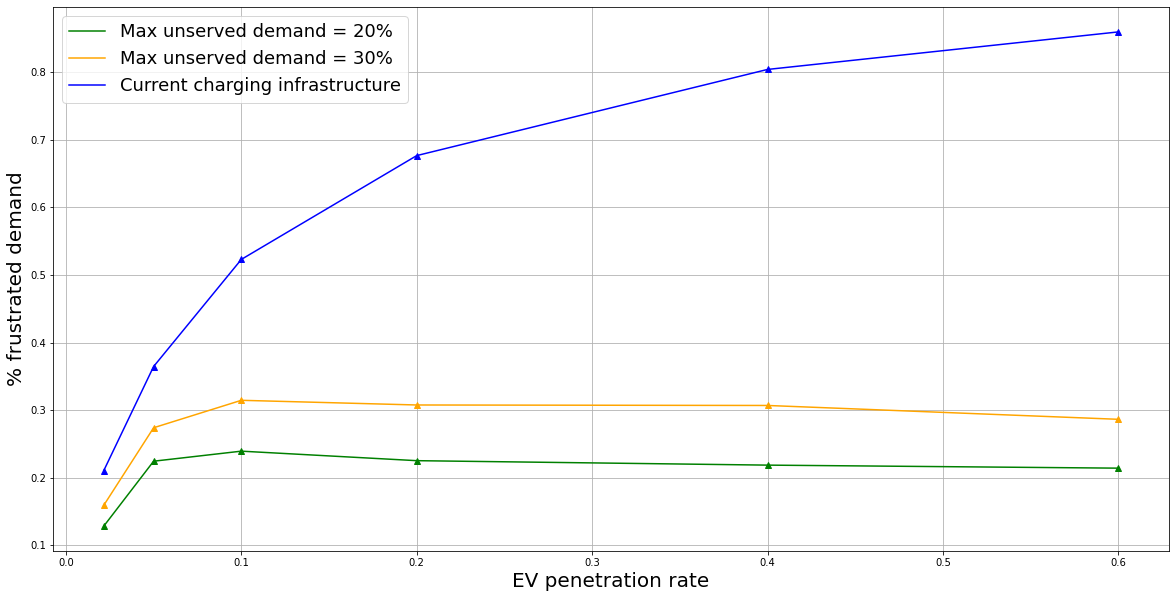

In [61]:
#Get the unmet demand ratios
penetrationRateList=[0.0216,0.05,0.1,0.2,0.4,0.6]
perimeterInKm=1
meanUtilizationRateList=[0.2,0.4]

demandList=[]
unservedDemandList=[]
unmetDemandRatioList = []

for meanUtilizationRate in meanUtilizationRateList:
    
    demand=[]
    unservedDemand=[]
    unmetDemandRatio=[]

    for penetrationRate in penetrationRateList:

        if penetrationRate==0.216:
            df=pd.read_pickle(fileDirectory+'data/4_ServeTheDemand_Experiment3/df_unservedDemandByHour_experiment3_aggregatedByLocation_penetrationRate='+
                     str(penetrationRate)+'_PerimeterInKm='+str(perimeterInKm))
        else: 
            df=pd.read_pickle(fileDirectory+'data/5_AddNewChargingStations_meanUtilizationRate='+str(meanUtilizationRate)+'/df_unservedDemandByHour_experiment3_aggregatedByLocation_penetrationRate='+\
                         str(penetrationRate)+'_PerimeterInKm='+str(perimeterInKm)+'_WithMoreCSForPenetratationRate'+\
                                str(penetrationRate))

        demand.append(df.demand.sum())
        unservedDemand.append(df.unservedDemand.sum())
        unmetDemandRatio.append(df.unservedDemand.sum()/df.demand.sum())
        
    demandList.append(demand)
    unservedDemandList.append(unservedDemand)
    unmetDemandRatioList.append(unmetDemandRatio)
    
#Plot the unserved demand function of the penetration rate
plt.plot(penetrationRateList,unmetDemandRatioList[0],label='Max unserved demand = 20%',color='green')
plt.plot(penetrationRateList,unmetDemandRatioList[1],label='Max unserved demand = 30%',color='orange')
plt.plot(penetrationRateList,unmetDemandRatio1,label='Current charging infrastructure',color='blue')
plt.plot(penetrationRateList,unmetDemandRatioList[0],'^',color='green')
plt.plot(penetrationRateList,unmetDemandRatioList[1],'^',color='orange')
plt.plot(penetrationRateList,unmetDemandRatio1,'^',color='blue')

plt.xlabel('EV penetration rate',fontsize=20)
plt.ylabel('% frustrated demand',fontsize=20)
#plt.title('% unserved demand function of penetration rate with the different charging infrastructure',fontsize=18)

# show legend
plt.legend(fontsize=18)
plt.grid()

# show graph
plt.show()

Why more supply ends up in more unserved demand? Is it due to the fact that the new charging stations have less supply than the initial ones? 

In [73]:
df_chargingStations=pd.read_pickle(fileDirectory+"data/Simulation/chargingStations_supply")
print('Mean supply by hour:',df_chargingStations.supplyByHour.mean())

Mean supply by hour: 51.83118811881188


In [67]:
meanUtilizationRate=0.4
penetrationRate=0.1
df_chargingStations=pd.read_pickle(fileDirectory+'data/5_AddNewChargingStations_meanUtilizationRate='+str(meanUtilizationRate)+'/df_chargingStations_supply_newCSforPenetrationRate='+
            str(penetrationRate))
print('Mean supply by hour:',df_chargingStations.iloc[202:,].supplyByHour.mean())

Mean supply by hour: 37.30769230769231


The fact that the unserved demand is higher with more supply might be due to the fact that the unserved demand mainly occurs at peak and that the added supply don't enable to serve much more this unserved demand. Furthermore, adding new charging stations at high unserved demand spots might end up concentrating demand to the new charging stations, that ends up saturated. That's why, accepting that demand is served by several charging stations might be a good idea..

# Number of charging stations & supply by penetration rate

In [68]:
df_chargingStations.supplyByHour.sum()/30*24

14523.119999999999

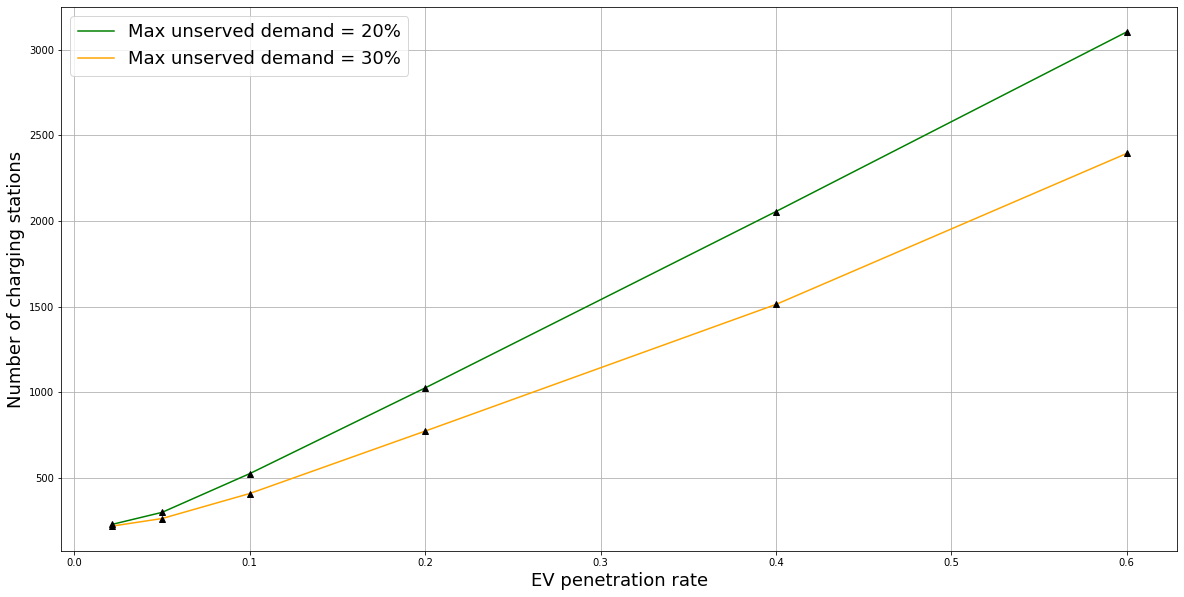

In [69]:
nbCSList=[]
supplyByDayList=[]


penetrationRateList=[0.0216,0.05,0.1,0.2,0.4,0.6]
perimeterInKm=1
meanUtilizationRateList=[0.2,0.4]

for meanUtilizationRate in meanUtilizationRateList:
    
    nbCS=[]
    supplyByDay=[]

    for i in range(len(penetrationRateList)):
        penetrationRate=penetrationRateList[i]
        if penetrationRate==0.216:
            df_chargingStations=pd.read_pickle(fileDirectory+"data/Simulation/chargingStations_supply")
        else: 
            df_chargingStations=pd.read_pickle(fileDirectory+'data/5_AddNewChargingStations_meanUtilizationRate='+str(meanUtilizationRate)+'/df_chargingStations_supply_newCSforPenetrationRate='+
            str(penetrationRate))

        nbCS.append(len(df_chargingStations))
        supplyByDay.append(df_chargingStations.supplyByHour.sum()*24)
        
    nbCSList.append(nbCS)
    supplyByDayList.append(supplyByDay)


#Plot the unserved demand function of the penetration rate
plt.plot(penetrationRateList,nbCSList[0],label='Max unserved demand = 20%',color='green')
plt.plot(penetrationRateList,nbCSList[1],label='Max unserved demand = 30%',color='orange')

plt.plot(penetrationRateList,nbCSList[0],'^',color='black')
plt.plot(penetrationRateList,nbCSList[1],'^',color='black')

plt.xlabel('EV penetration rate',fontsize=18)
plt.ylabel('Number of charging stations',fontsize=18)
#plt.title('Number of additional charging stations function of penetration rate',fontsize=18)

# show legend
plt.legend(fontsize=18)
plt.grid()

# show graph
plt.show()

In [74]:
df_chargingStations=pd.read_pickle(fileDirectory+"data/Simulation/chargingStations_supply")
print("Initial supply by day:",df_chargingStations.supplyByHour.sum())

Initial supply by day: 10469.9


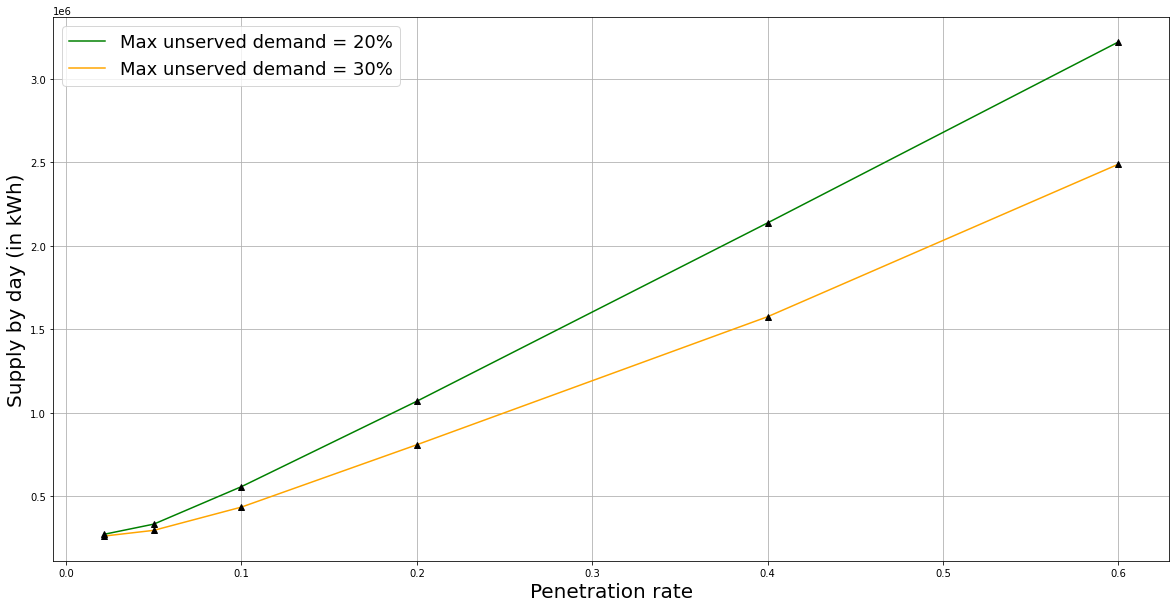

In [76]:
#Plot the unserved demand function of the penetration rate
plt.plot(penetrationRateList,supplyByDayList[0],label='Max unserved demand = 20%',color='green')
plt.plot(penetrationRateList,supplyByDayList[1],label='Max unserved demand = 30%',color='orange')
plt.plot(penetrationRateList,supplyByDayList[0],'^',color='black')
plt.plot(penetrationRateList,supplyByDayList[1],'^',color='black')

plt.xlabel('Penetration rate',fontsize=20)
plt.ylabel('Supply by day (in kWh)',fontsize=20)
#plt.title('Supply by day function of penetration rate',fontsize=18)

# show legend
plt.legend(fontsize=18)
plt.grid()

# show graph
plt.show()

In [98]:
servedDemand=np.multiply(demand,np.ones(6)-unmetDemandRatioList[0])
print("% increase served Demand with a 20% frustrated demand limit:",servedDemand[-1]/servedDemand[2])

% increase served Demand with a 20% frustrated demand limit: 6.205747670521373


In [97]:
print("% increase in supply with a 20% frustrated demand limit:",supplyByDayList[0][-1]/supplyByDayList[0][2]) #df_chargingStations.supplyByHour.sum()

% increase in supply: 5.770218841246565


In [99]:
servedDemand1=np.multiply(demand,np.ones(6)-unmetDemandRatioList[1])
print("% increase served Demand with a 30% frustrated demand limit:",servedDemand1[-1]/servedDemand1[2])

% increase served Demand with a 30% frustrated demand limit: 6.253691534697951


In [100]:
print("% increase in supply with a 30% frustrated demand limit:",supplyByDayList[1][-1]/supplyByDayList[1][2]) #df_chargingStations.supplyByHour.sum()

% increase in supply with a 20% frustrated demand limit: 5.711830515756945


For the max unserved demand of 30%, the supply has been multiplied by 10 for the EV penetration rate 60%. But the served demand has roughly be multiplied by 1.5. It is due to the fact that the unserved demand peaks at some hours and at some locations. So at some point, the additional supply is only used for fulfilling these unserved demands at specific hours and locations. All the remaining supply is not used. That's why, the more charging stations the lower the utilisation rate. But low utilization rate (20%) has to be accepted to ensure a high served demand.

As a result, having mobile charging stations really makes sense to adapt the supply through time and space in Cph. 

# Difference in supply by day when going from a max unserved demand of 30% to 20%

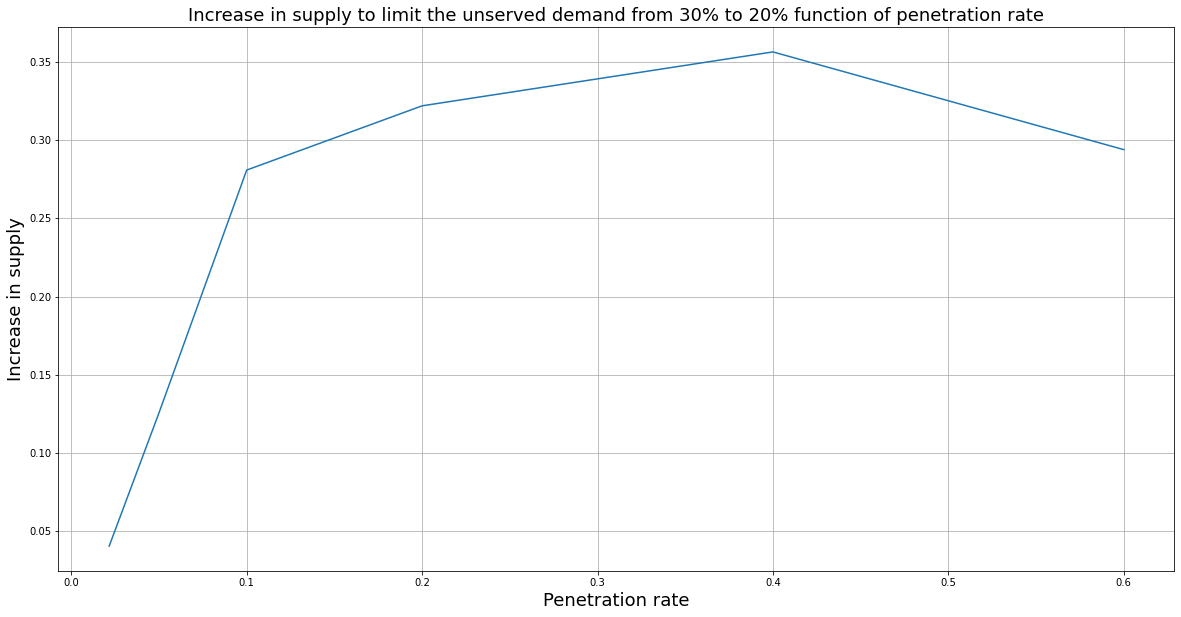

In [58]:
increaseInSupplyInPercent=(np.array(supplyByDayList[0])-np.array(supplyByDayList[1]))/np.array(supplyByDayList[1])

plt.plot(penetrationRateList,increaseInSupplyInPercent)
plt.xlabel('Penetration rate',fontsize=18)
plt.ylabel('Increase in supply',fontsize=18)
plt.title('Increase in supply to limit the unserved demand from 30% to 20% function of penetration rate',fontsize=18)
plt.grid()

Going from a max unserved demand of 30% to 20% represents increasing the served demand by approximately 15%. But it requires 30% more supply to do so. The last % of unserved demand are therefore the most supply demanding. It is certainly due to the fact that the peaks of demand are tough to manage.

# Show the deployment of charging stations

In [8]:
data=[]
penetrationRateList=[0.0216,0.05,0.1,0.2,0.4,0.6]
meanUtilizationRate=0.2

for i in range(len(penetrationRateList)):
    penetrationRate=penetrationRateList[i]
    if penetrationRate==0.216:
        df_chargingStations=pd.read_pickle(fileDirectory+"data/Simulation/chargingStations_supply")
    else: 
        df_chargingStations=pd.read_pickle(fileDirectory+'data/5_AddNewChargingStations_meanUtilizationRate='+str(meanUtilizationRate)+'/df_chargingStations_supply_newCSforPenetrationRate='+
        str(penetrationRate))
    
    df_chargingStations['count']=0.5
    data.append(np.vstack(
        (df_chargingStations.latitude, df_chargingStations.longitude,df_chargingStations['count'])).T.tolist())

    
index=penetrationRateList
plotHeatmapWithTime(data,index)

# Show the utilization rate

In [39]:
utilizationRateList=[]
penetrationRateList=[0.0216,0.05,0.1,0.2,0.4,0.6]

for meanUtilizationRate in [0.2,0.4]:
    utilizationRate=[]
    
    for i in range(len(penetrationRateList)):
        penetrationRate=penetrationRateList[i]
        if penetrationRate==0.216:
            df_chargingStations=pd.read_pickle(fileDirectory+"data/Simulation/chargingStations_supply")
            df=pd.read_pickle(fileDirectory+'data/4_ServeTheDemand_Experiment3/df_unservedDemandByHour_experiment3_aggregatedByLocation_penetrationRate='+
                     str(penetrationRate)+'_PerimeterInKm='+str(perimeterInKm))
        else: 
            df_chargingStations=pd.read_pickle(fileDirectory+'data/5_AddNewChargingStations_meanUtilizationRate='+str(meanUtilizationRate)+'/df_chargingStations_supply_newCSforPenetrationRate='+
            str(penetrationRate))
            df=pd.read_pickle(fileDirectory+'data/5_AddNewChargingStations_meanUtilizationRate='+str(meanUtilizationRate)+'/df_unservedDemandByHour_experiment3_aggregatedByLocation_penetrationRate='+\
                         str(penetrationRate)+'_PerimeterInKm='+str(perimeterInKm)+'_WithMoreCSForPenetratationRate'+\
                                str(penetrationRate))
            
        utilizationRate.append(df.servedDemand.sum()/df_chargingStations.supplyByMonth.sum())
        
    utilizationRateList.append(utilizationRate)



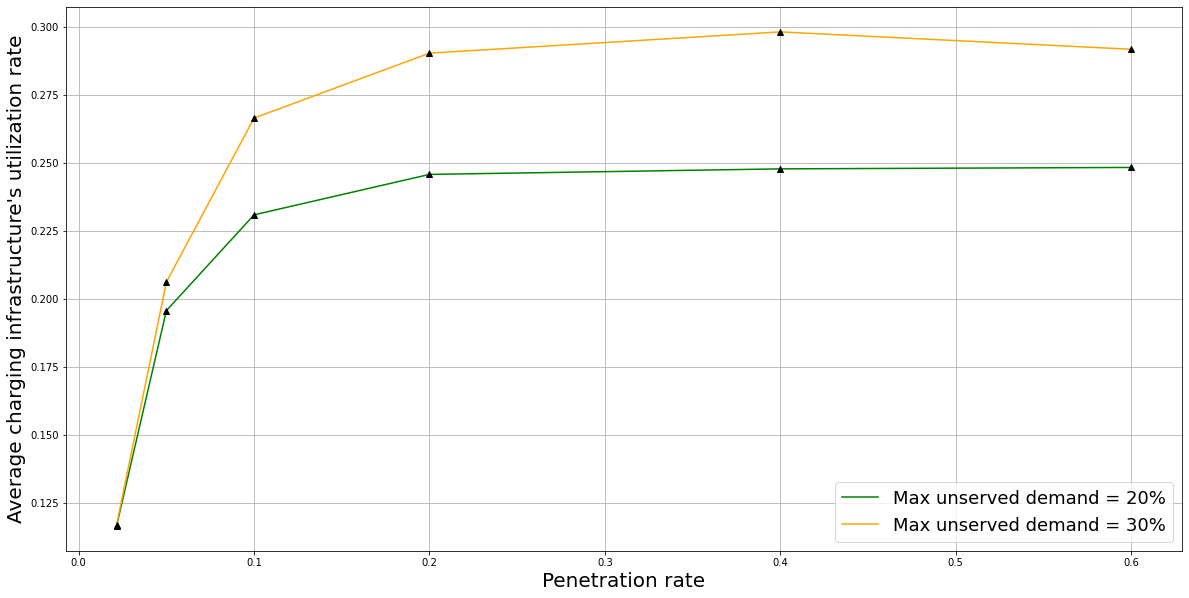

In [45]:
#Plot the unserved demand function of the penetration rate
plt.plot(penetrationRateList,utilizationRateList[0],label='Max unserved demand = 20%',color='green')
plt.plot(penetrationRateList,utilizationRateList[1],label='Max unserved demand = 30%',color='orange')
plt.plot(penetrationRateList,utilizationRateList[0],'^',color='black')
plt.plot(penetrationRateList,utilizationRateList[1],'^',color='black')

plt.xlabel('Penetration rate',fontsize=20)
plt.ylabel("Average charging infrastructure's utilization rate",fontsize=20)
#plt.title('Supply by day function of penetration rate',fontsize=18)

# show legend
plt.legend(fontsize=18)
plt.grid()

# show graph
plt.show()